In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from scipy.interpolate import interp1d


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Make a plot with the photometry, spectra and fits to both stars

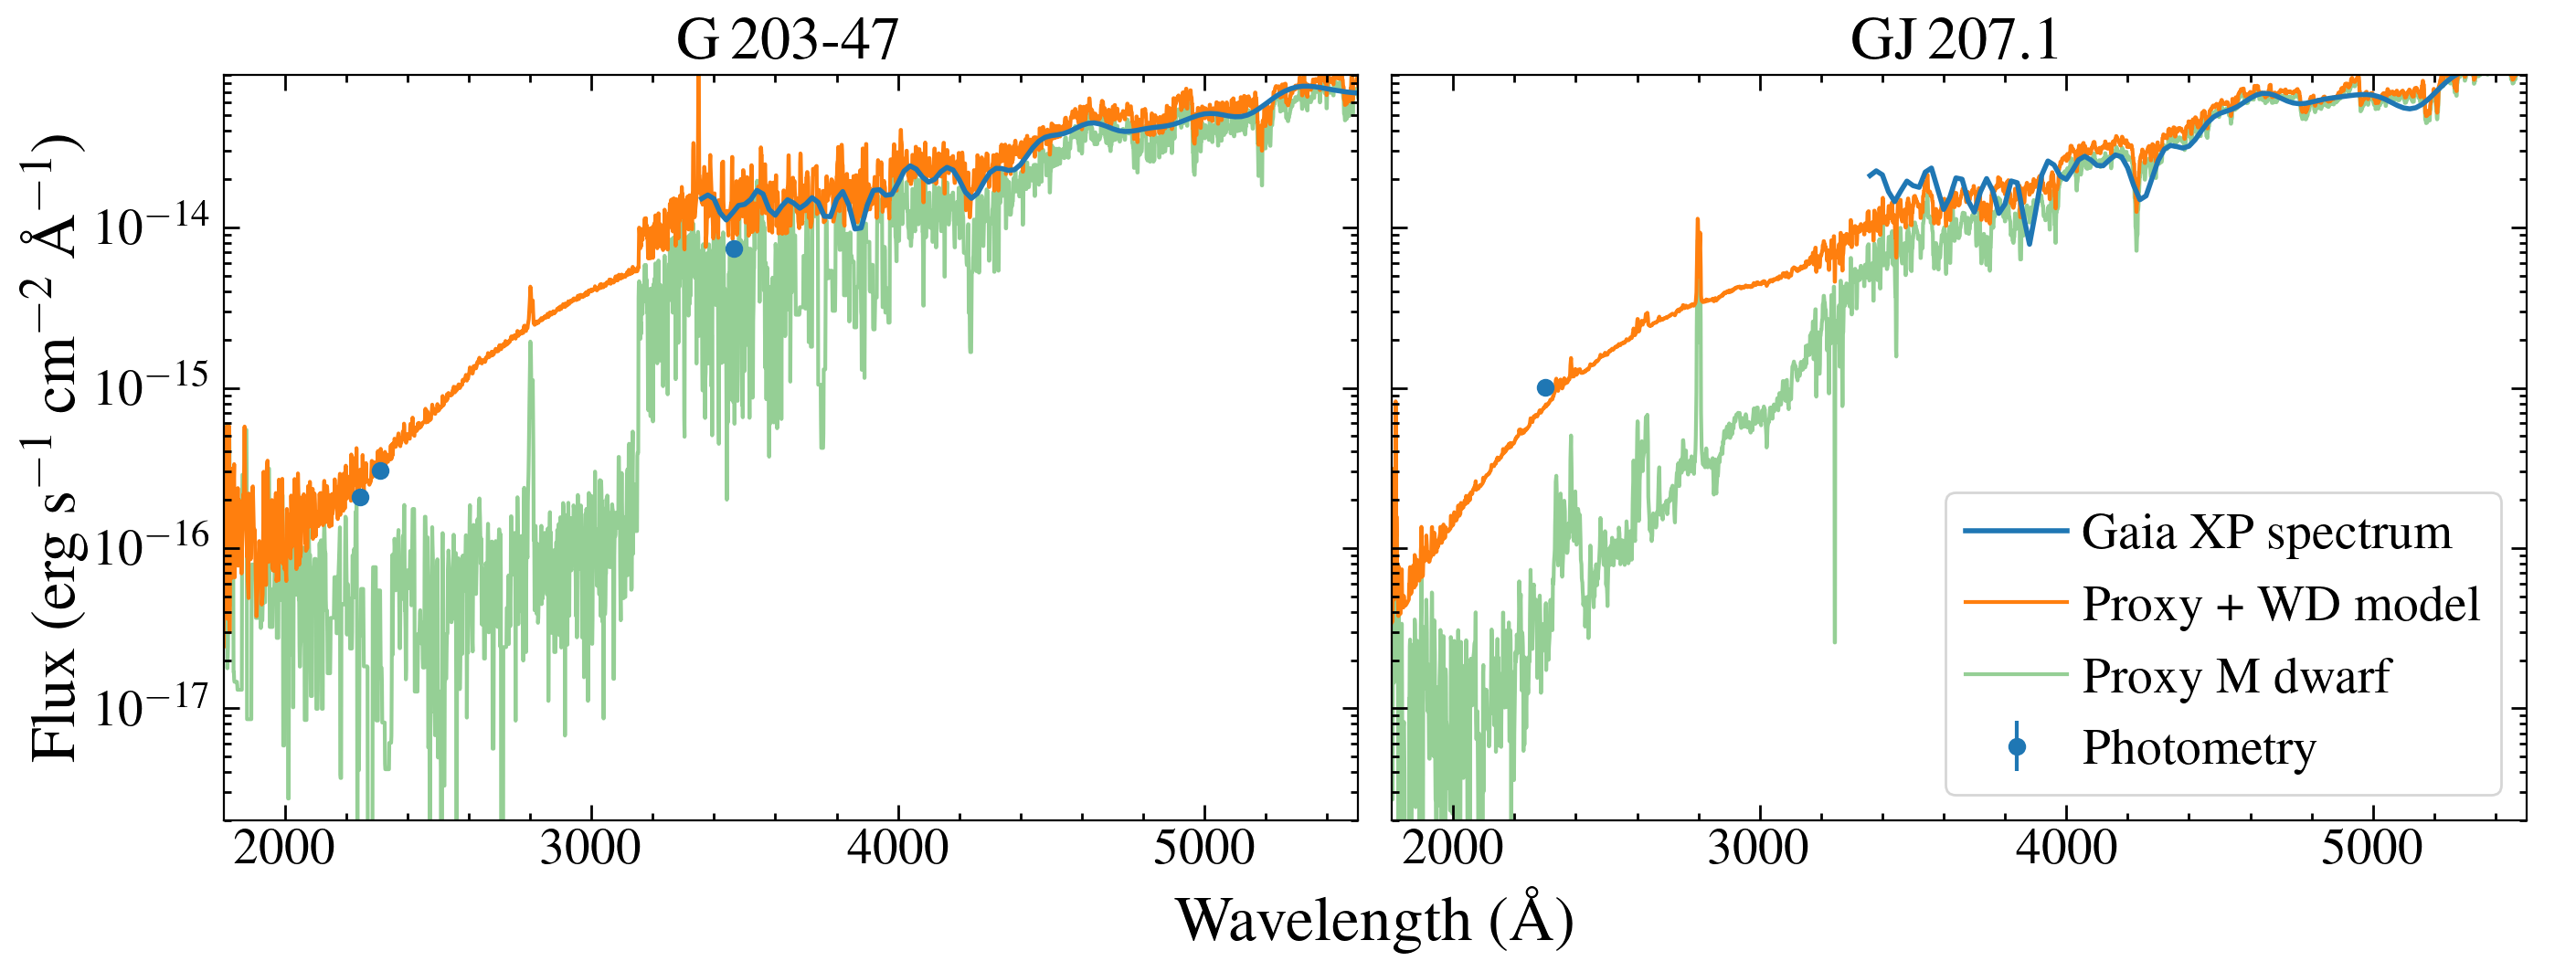

In [85]:
fig, ax = plt.subplots(ncols =2, sharex=True, figsize=(14, 5.5))

ax[0].set_title('G\,203-47')
ax[1].set_title('GJ\,207.1')

gaia = glob.glob('data/*gaia*')
# print(gaia)
for i, spec in enumerate(gaia):
    # print(spec)
    data = Table.read(spec)
    mask = data['type'] == 'XP'
    ax[i].plot(data['wavelength'][mask]*10, data['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA), 
               label = 'Gaia XP spectrum', c='C0', lw=2)
    
#g203
phot_w = [3465, 2246, 1530, 2310]
phot_f = [7.411776e-15, 2.0942781e-16, 8.96470249e-17, 3.06191581e-16]
phot_e = [1.7897673e-16, 1.3159324943194897e-17, 3.45781382e-17, 2.69673319e-17]
ax[0].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', c='C0')

#gj207
# 2300.79 1.0049178765233773e-15 1.0487355277243325e-16
phot_w = [2300.79]
phot_f = [1.0049178765233773e-15]
phot_e = [1.0487355277243325e-16]
ax[1].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', label ='Photometry', c='C0')

mods = ['g203_model.dat', 'gj207_model.dat']
for i, mod in enumerate(mods):
    mw, mf = np.loadtxt(mod, unpack=True)
    ax[i].plot(mw, mf, zorder=-5, label = 'Proxy + WD model', c='C1')

proxys = ['/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/L-980-5/hlsp_muscles_multi_multi_l-980-5_broadband_v24_adapt-const-res-sed.fits',
         '/media/david/2tb_ext_hd/hddata/carmenes_binary//gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits']

scales = [3.1149330983671675, 0.36117578882221896/1.4691682547408482]

for i, proxy in enumerate(proxys):
    data = fits.getdata(proxy, 1)
    ax[i].plot(data['WAVELENGTH'], data['FLUX']*scales[i], label = 'Proxy M dwarf', alpha=0.5, zorder=-10, c='C2')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].legend(frameon=True, loc=4)
ax[0].set_xlim(1800, 5500)
ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)
ax[0].set_ylim(2e-18, 9e-14)
ax[1].set_ylim(2e-18, 9e-14)
ax[1].set_yticklabels([])

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.xlabel('Wavelength (\AA)', size=25)
plt.tight_layout()
plt.subplots_adjust(wspace=0.03, bottom=0.13, left=0.09, right=0.99)

fig.savefig('plots/both_spec_model.pdf')

type,wavelength,flux,flux_error
,nm,W / (m2 nm),
object,float64,float32,float32
XP,336.0,1.5136446e-16,3.748029e-17
XP,338.0,1.5953564e-16,2.790904e-17
XP,340.0,1.5114598e-16,2.2418926e-17
XP,342.0,1.2354582e-16,1.958952e-17
XP,344.0,1.1142852e-16,1.826131e-17
XP,346.0,1.231983e-16,1.80776e-17
XP,348.0,1.3712008e-16,1.8844888e-17
XP,350.0,1.3940751e-16,2.0261748e-17
